### The purpose of this notebook is to explain the process of creating surface profiles. For hubble images these will be surface brightness profiles. For the ALMA moments maps this would be Flux density profiles. 

First it is important to generate a test case that we can use to test our functions against. In order to do this we generate some 2d emission using a sersic profile which we will have to recover later. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.modeling import models
from sersic_fitter import SersicFitter, sersic
from astropy.modeling.models import Sersic1D
from calc_channels import cutout_annulus, cutout_data, calc_rms
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import emcee 
import corner 
from scipy.optimize import minimize
from abc import ABC, abstractmethod


In /home/trystan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/trystan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/trystan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/trystan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/trystan/.local/lib/python3.6/site-packages/matplotlib/mpl-d

In [2]:
NUMBER_OF_ROWS = 240
NUMBER_OF_COLUMNS = 240

y, x = np.mgrid[:NUMBER_OF_ROWS, :NUMBER_OF_COLUMNS]
center = (len(x)//2, len(y)//2)
print(center)

amplitude = 20; r_eff = 20; sersix_index = 1

def plot(amplitude, r_eff, sersix_index):
    sersic_model = models.Sersic2D(amplitude=amplitude, r_eff = r_eff, n=sersix_index, x_0=0.5*NUMBER_OF_COLUMNS, y_0 = 0.5*NUMBER_OF_ROWS, ellip=0., theta=0.0)
    image = sersic_model(x,y)
    plt.subplot(121)
    plt.imshow(image)
    plt.colorbar()
    plt.subplot(122)
    x_plotting = np.linspace(0, 120,1000)
    s = Sersic1D(amplitude=amplitude, r_eff = r_eff, n = sersix_index)
    plt.plot(x_plotting, sersic(x_plotting, amplitude, r_eff, sersix_index, 0), label='mine')
    plt.plot(x_plotting, s(x_plotting), label = 'astropy')
    plt.legend()
    plt.show()

interact(plot, amplitude = (1,20), r_eff = (1, 20), sersix_index = (0.3,2.5,0.1))

(120, 120)


interactive(children=(IntSlider(value=10, description='amplitude', max=20, min=1), IntSlider(value=10, descrip…

<function __main__.plot(amplitude, r_eff, sersix_index)>

In [21]:
"""Writing a serisc fitter using MCMC"""

def model(theta, radius):
    amplitude, effective_radius, sersic_index, offset = theta 
    model = amplitude * np.exp(-(2*sersic_index -1./3) * ((radius/effective_radius)**(1.0/sersic_index) - 1.0)) + offset
    return model 

def lnlike(theta, x, y, y_err):
    LnLike = -0.5 * np.sum(((y - model(theta, x)) / (y_err))**2 )
    return LnLike

def lnprior(theta):
    amplitude, effective_radius, sersic_index, offset = theta 
    if (0 < amplitude < 10) and ( 0 < effective_radius < 10) and (0.3 <sersic_index < 10) and (0 < offset < 10):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not lp == 0:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)



In [22]:
def trystan_method():
    y_vals, x_vals = [], []
    for i in range(len(radii) - 1):
        if radii[i] == 0:
            x_vals.append(0)
            cutout = cutout_data(image, center, radii[i+1])
        else:
            cutout = cutout_annulus(image, center, radii[i], radii[i+1])
            x_vals.append((radii[i] + radii[i+1])/2)
        n = len(np.where(cutout != 0)[0])
        flux = np.sum(cutout)
        y_vals.append(flux / n)
    return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)

def offcenter_method():
    y_vals, x_vals = [], []
    for i in range(len(radii) - 1):
        if radii[i] == 0:
            cutout = cutout_data(image, center, radii[i+1])
        else:
            cutout = cutout_annulus(image, center, radii[i], radii[i+1])
        x_vals.append((radii[i] + radii[i+1])/2)
        n = len(np.where(cutout != 0)[0])
        flux = np.sum(cutout)
        y_vals.append(flux / n)
    return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)

def all_anuli_method():
    y_vals, x_vals = [], []
    for i in range(len(radii) - 1):
        if radii[i] == 0:
            pass
        else:
            cutout = cutout_annulus(image, center, radii[i], radii[i+1])
            x_vals.append((radii[i] + radii[i+1])/2)
            n = len(np.where(cutout != 0)[0])
            flux = np.sum(cutout)
            y_vals.append(flux / n)
    return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)


  0%|          | 0/100 [00:00<?, ?it/s]/home/trystan/.local/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 12/100 [00:00<00:00, 114.78it/s]

(array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51.,
       53., 55., 57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77.,
       79., 81., 83., 85., 87., 89., 91., 93., 95., 97.]), array([9.55013404e+01, 6.76116614e+01, 5.01193968e+01, 3.85386277e+01,
       3.01645598e+01, 2.42334593e+01, 1.96631592e+01, 1.60297929e+01,
       1.32497199e+01, 1.09776036e+01, 9.16346929e+00, 7.75152728e+00,
       6.54626978e+00, 5.54995766e+00, 4.73312415e+00, 4.04870922e+00,
       3.47527194e+00, 2.99881210e+00, 2.59536275e+00, 2.24089883e+00,
       1.94290202e+00, 1.69093324e+00, 1.47526507e+00, 1.29160739e+00,
       1.12850988e+00, 9.86702144e-01, 8.67275651e-01, 7.63524118e-01,
       6.72584471e-01, 5.94192441e-01, 5.25221503e-01, 4.64449759e-01,
       4.11417227e-01, 3.65077082e-01, 3.24501464e-01, 2.88965415e-01,
       2.56985332e-01, 2.28645297e-01, 2.03881514e-01, 1.82080198e-01,
       1.62902

  0%|          | 13/5000 [00:00<00:39, 127.43it/s]

running fit...


100%|██████████| 5000/5000 [00:50<00:00, 98.39it/s] 


1.1359610651041303 9.949355206373411e-08 1.027428930822083e-07
48.50000000484799 1.0203471134673237e-07 9.360158514937211e-08
0.7499999997148935 9.727426064642941e-08 1.0457596555379922e-07
-0.040847778867334886 9.993230506294415e-08 1.0112961414815436e-07
[-0.04084788 -0.04084778 -0.04084768]


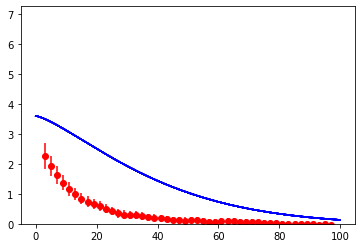

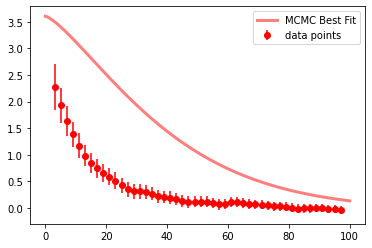

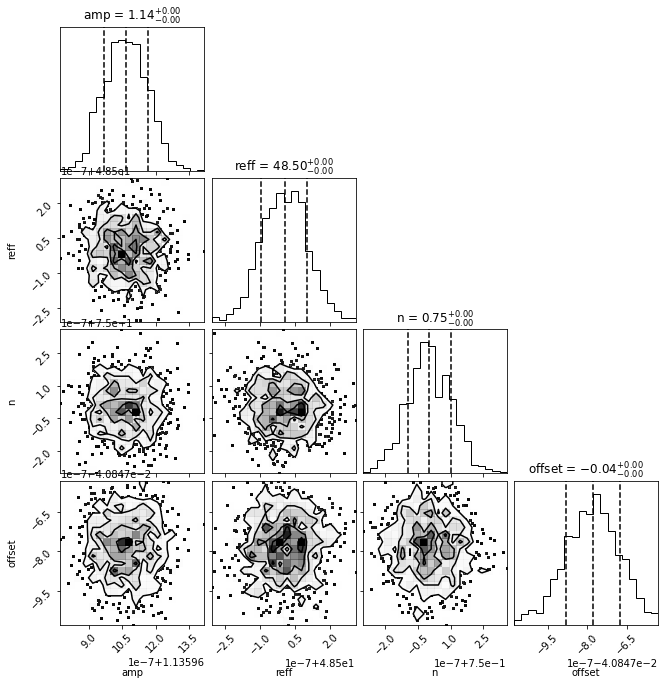

In [26]:

amplitude = 10
r_eff = 20
n = 1.5
sersic_model = models.Sersic2D(amplitude=amplitude, r_eff = r_eff, n=n, x_0=0.5*NUMBER_OF_COLUMNS, y_0 = 0.5*NUMBER_OF_ROWS, ellip=0., theta=0.0)
image = sersic_model(x,y)

radii = np.arange(0,100,2)
#data = trystan_method()
data = offcenter_method()
print(data)
#data = all_anuli_method()
#fit_params = SersicFitter(data[0], data[1], data[2]).fit_sersic(sersic)

data = np.loadtxt('DELETE_test_file.txt', unpack=True)

def fit_sersic_mcmc(x, y, y_err):
    nwalkers = 1000
    niter = 5000
    data = (x, y, y_err)
    initial = np.array([np.max(y)/2, np.max(x)/2, 0.75, np.min(y)])
    ndim = len(initial)
    p0 = [initial + 1e-7* np.random.randn(ndim) for i in range(nwalkers)]
    sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)
    return sampler, pos, prob, state

def main(p0, nwalkers, niter, ndim, lnprob, data):
    print('burning in...')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    p0, _, _ = sampler.run_mcmc(p0, 100, progress= True)
    sampler.reset()

    print('running fit...')
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state 

def sample_walkers(x_for_plot, nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i, x_for_plot)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread

sampler, pos, prob, state = fit_sersic_mcmc(data[0], data[1], data[2])
new_samples = sampler.flatchain


x_plotting = np.linspace(0, 100, 1000)
plt.ion()
samples = sampler.get_chain(discard = 200,thin=10, flat = True)

best_params = []
for i in range(4):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    best_params.append(mcmc[1])
    print (mcmc[1], q[0], q[1])
best_params = np.array(best_params)

theta_max = np.percentile(samples[:, i], [16, 50, 84]) #samples[np.argmax(sampler.flatlnprobability)]
print(theta_max)
for theta in samples[np.random.randint(len(samples), size = 100)]:
    plt.plot(x_plotting, model(theta, x_plotting), color='b', alpha=0.1)
plt.ylim(0, np.max(data[1]) + 5)
plt.errorbar(data[0], data[1], data[2], fmt = 'ro')
plt.show()

plt.errorbar(data[0], data[1], data[2], fmt = 'ro', label = 'data points')
plt.plot(x_plotting, sersic(x_plotting, *best_params),color='r', lw=3, alpha=0.5, label = 'MCMC Best Fit')
# plt.plot(x_plotting, sersic(x_plotting, *fit_params[0]),color='g', lw=4, alpha=0.5, label = 'Least_squares Best Fit')
#plt.plot(x_plotting, sersic(x_plotting, amplitude, r_eff, n, 0), color='k', label='Truth', ls=':', lw=6)
plt.legend()
plt.show()

labels = ['amp', 'reff', 'n', 'offset']
fig = corner.corner(samples, show_titles=True, labels = labels, plot_datapoints = True, quantiles = [0.16, 0.5, 0.84])




In [11]:
x_plotting = np.linspace(0, 100, 1000)
def func(amplitude, r_eff, n):
    theta = np.array([amplitude, r_eff, n, 0])
    labels = ['Trystan', 'Offcenter', 'No center']


    def trystan_method():
        y_vals, x_vals = [], []
        for i in range(len(radii) - 1):
            if radii[i] == 0:
                x_vals.append(0)
                cutout = cutout_data(image, center, radii[i+1])
            else:
                cutout = cutout_annulus(image, center, radii[i], radii[i+1])
                x_vals.append((radii[i] + radii[i+1])/2)
            n = len(np.where(cutout != 0)[0])
            flux = np.sum(cutout)
            y_vals.append(flux / n)
        return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)

    def offcenter_method():
        y_vals, x_vals = [], []
        for i in range(len(radii) - 1):
            if radii[i] == 0:
                cutout = cutout_data(image, center, radii[i+1])
            else:
                cutout = cutout_annulus(image, center, radii[i], radii[i+1])
            x_vals.append((radii[i] + radii[i+1])/2)
            n = len(np.where(cutout != 0)[0])
            flux = np.sum(cutout)
            y_vals.append(flux / n)
        return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)

    def all_anuli_method():
        y_vals, x_vals = [], []
        for i in range(len(radii) - 1):
            if radii[i] == 0:
                pass
            else:
                cutout = cutout_annulus(image, center, radii[i], radii[i+1])
                x_vals.append((radii[i] + radii[i+1])/2)
                n = len(np.where(cutout != 0)[0])
                flux = np.sum(cutout)
                y_vals.append(flux / n)
        return np.array(x_vals), np.array(y_vals), 0.4 * np.array(y_vals)

    def make_plot(method, label = None):
        x_vals, y_vals, y_errs = method()
        x_plotting = np.linspace(x_vals[0], x_vals[-1], 1000)
        #fit_params = SersicFitter(x_vals, y_vals, y_errs).fit_sersic(sersic)
        #errors.append(fit_params[2])
        #inaccuracies.append(np.abs(fit_params[0] - theta))
        plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt = 'o', label=label)
        
        #plt.plot(x_plotting, sersic(x_plotting,*fit_params[0]), label=label , lw=2)

    methods =[
        trystan_method,
        #all_anuli_method, 
        offcenter_method,
    ]



    sersic_model = models.Sersic2D(amplitude=amplitude, r_eff = r_eff, n=n, x_0=0.5*NUMBER_OF_COLUMNS, y_0 = 0.5*NUMBER_OF_ROWS, ellip=0., theta=0.0)
    image = sersic_model(x,y)
    radii = np.arange(0, 100, 5) 
    errors = []
    inaccuracies = []
    plt.title(str(n))
    plt.plot(x_plotting, sersic(x_plotting, amplitude, r_eff, n, 0), label='True', lw=3)
    for i, method in enumerate(methods):
        make_plot(method, labels[i])
    plt.legend()
    plt.show()

interact(func, amplitude = (1,20), r_eff = (1, 50), n = (0.3,1.5,0.05))


interactive(children=(IntSlider(value=10, description='amplitude', max=20, min=1), IntSlider(value=25, descrip…

<function __main__.func(amplitude, r_eff, n)>

### Uncertainties

#### Propogation of log error


\begin{align*}
f & = a\log_{10}\left(bA\right) \\
\Rightarrow u(f) & \approx a\frac{u(A)}{A \ln\left(10\right)}  
\end{align*}

therefore:
\begin{align*}
\text{ST}_{\rm mag} & = -2.5 \log\left(F_{\lambda}\right) -21.1 \\
u(\text{ST}_{\rm mag}) & \approx 2.5 \frac{u(F_{\lambda})}{F_{\lambda} \ln\left(10\right)}
\end{align*}

Taking an "average flux": $\bar{F_{\lambda}}  = \frac{F_{\lambda}}{A}$ where $A$ is the area of the region. We get:

\begin{align*}
u\left(\bar{\text{ST}_{\rm mag}}\right)  & \approx 2.5\frac{u\left(\frac{F_{\lambda}}{A}\right)}{\frac{F_{\lambda}}{A}} \\
& \approx 2.5 \frac{\frac{u(F_{\lambda})}{A}}{\frac{F_{\lambda}}{A} \ln\left(10\right)} \\
& \approx 2.5 \left(\frac{u(F_{\lambda})}{A} \frac{A}{F_{\lambda} \ln\left(10\right)}\right) \\
& \approx 2.5 \frac{u\left(F_{\lambda}\right)}{F_{\lambda} \ln\left(10\right)} \\
& = u\left(\text{ST}_{\rm mag}\right)
\end{align*}


Therefore the uncertainty associated with the magnitude is the same as the uncertainty of the surface brightness so long as the uncertainty of the area is 0. This is to be expected since the $b$ variable in the first equation is not present in the uncertainty calculation.

## Working out the uncertainty of an aperture
In order to work out the uncertainty of an aperture we need to consider the uncertainty of any given pixel $p_i$. Each pixel has a value which would be determined as the measured photons minus the background emission. This means that the uncertainty of ever pixel would be:
\begin{equation*}
u(\rm pix) = \sqrt{u(\gamma)^2 + u(\rm \beta)^2}
\end{equation*}

I.e. uncertainty of a pixel is made up of 1) the background noise, which is simply the rms and 2) the poisson uncertainty associated with counting. The poisson noise is straight forward as is equal to the $\sqrt{p_i}$ where $p_i$ is the value of the pixel. Thus, 


\begin{align*}
u(\rm reg) &= \sqrt{u(\rm pix_1)^2 + u(\rm pix_2)^2 + \cdots + u(\rm pix_{n-1})^2 + u(\rm pix_{n})^2} \\
&= \sqrt{\sum\limits_{i=1}^n u(\rm pix_i)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \left(\sqrt{u(\gamma_i)^2 + u(\beta_i)^2}\right)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \left(u(\gamma_i)^2 + u(\rm \beta_i)^2\right)} \\
&= \sqrt{\sum\limits_{i=1}^n u(\gamma_i)^2 + \sum\limits_{i=1}^n u(\beta_i)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \sqrt{\gamma_i}^2 + \sum\limits_{i=1}^n \sigma^2} \\
&= \sqrt{\sum\limits_{i=1}^n \gamma_i + \sum\limits_{i=1}^n \sigma^2} \\
&= \sqrt{F_{\rm sum, reg} + \sigma^2n}
\end{align*}


